## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Antigone Fogel, Nan Fletcher-Lloyd, Anastasia Gailly De Taurines, Iona Biggart, Payam Barnaghi
Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London

**Spring 2026**

# Lab 5: SVM, Decision Trees, and Random Forest:

This tutorial will focus on Support Vector Machines, Decision Trees, and Random Forest. We will be using [sci-kit learn's](https://scikit-learn.org/stable/index.html) package for these models.

In [1]:
# import sklearn objects
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

# import numpy and pandas
import numpy as np
import pandas as pd

# import plotting functions
import matplotlib.pyplot as plt
import matplotlib.colors
from cycler import cycler
binary_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#332288', 'white', '#AA4499'])
plt.rcParams["axes.prop_cycle"] = cycler(
    color=['#332288','#88CCEE','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499']
    )

# class for holding the random state throughout the notebook
# this keeps results consistent
class RandomState(object):
    def __init__(self, random_state=None):
        self.random_state = random_state
    def next(self):
        self.random_state,\
            out_state = np.random.default_rng(self.random_state).integers(0, 1e9, size=(2,))
        return out_state

In [2]:
random_state = RandomState(42)

## Loading the Data:

In this tutorial, we will be looking at a [breast cancer dataset provided with the sci-kit learn package](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [3]:
datasets

<module 'sklearn.datasets' from '/Users/ac4919/miniforge3/envs/ml4n/lib/python3.11/site-packages/sklearn/datasets/__init__.py'>

In [4]:
# loading the dataset
bc_data = datasets.load_breast_cancer(as_frame=True)

In [5]:
# accessing the data or the target from the dataset loaded above
bc_features = bc_data.data
bc_target = bc_data.target

The first 5 lines of this data look as follows:

In [6]:
bc_features.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33           184.60   
1                 0.05667  ...         24.99          23.41           158.80   
2                 0.05999  ...         23.57          25.53           152.50   
3                 0.09744  ...         14.91          26.50            98.87   
4                 0.05883  ...         22.54          16.67           152.20   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 30 columns]

And the targets are as follows (where 0 = Malignant and 1 = Benign):

In [7]:
bc_target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In the code cell below, cut the dataset so it includes mean features only to make things slightly easier:

In [ ]:
bc_mean_features = bc_features[]

We can use **[TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)** (t-Distributed Stochastic Neighbour Embedding), a machine learning algorithm primarily used for **dimensionality reduction** and **visualising high-dimensional data** to visualise the data in two dimensions. Here, we specify `n_components=2` to reduce our data to 2 dimensions.

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/3504014926.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


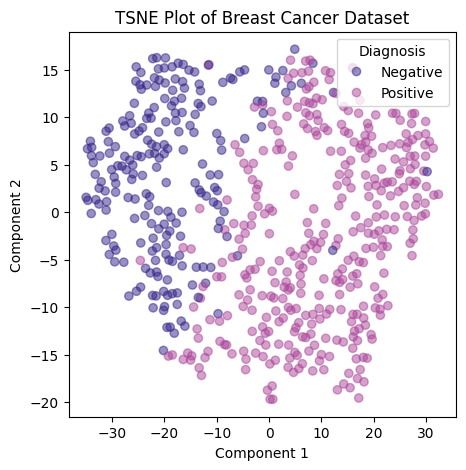

In [9]:
# import TSNE
from sklearn.manifold import TSNE

# pre-processing the data
scaler = StandardScaler()
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_state.next())
x = tsne.fit_transform(scaler.fit_transform(bc_mean_features))

# setting the figure
fig, ax = plt.subplots(1,1,figsize=(5,5))

# plotting the data
scatter = ax.scatter(
    x=x[:,0], # All rows in the first column
    y=x[:,1], # All rows in the second column
    c=bc_target.astype(bool), # Colour
    alpha=0.5, 
    cmap=binary_cmap,
    )

# adding the legend
ax.legend(
    scatter.legend_elements(num=1)[0],
    ['Negative', 'Positive'],
    loc="upper right", 
    title="Diagnosis",
    )

# set title and labels
ax.set_title('TSNE Plot of Breast Cancer Dataset')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# showing plot
fig.show()

In the code cell below, plot a histogram for each of the features we selected above:

In [1]:
## CODE HERE ##

## SVM

[Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) is a classic machine learning classifier that attempts to separate classes of data using a [hyperplane](https://en.wikipedia.org/wiki/Hyperplane). 

It works by maximising the width of the gap between two categories, when they are linearly separable, by minimising the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss).

Different kernels can be used to learn different boundaries between classes, that might have different distributions. In the following examples, we will see where these different kernels will be helpful.

See Also: https://scikit-learn.org/stable/modules/svm.html#support-vector-machines

### The Basics

To access the [SVM code from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), we need to import it as follows:

In [11]:
from sklearn.svm import SVC

What arguments can we supply this model and what are the defaults?

In [12]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

These arguments are explained in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). For the following experiments, we will be varying the kernel function, to see how it can affect the classification performance on different datasets:

We will start by seeing how we can train, and evaluate the performance of our model, and understand the model's decision boundary.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Here are the train and test splits of a **synthetic** dataset made using [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html):

In [14]:
# make synthetic dataset
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

In [15]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/4104690370.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


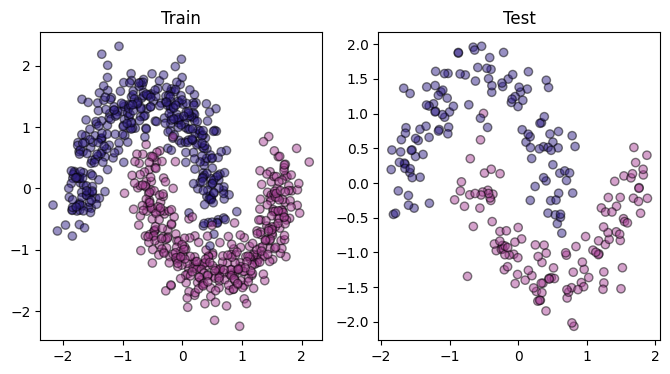

In [16]:
# plot the train and test splits for the synthetic data
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Test')

fig.show()

The model can be fit as follows:

In [17]:
# start with linear kernel
svc = SVC(kernel='linear', random_state=random_state.next())

In [18]:
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=745137746)

Let's evaluate the model and see how well its decision boundary fit the data:

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
print(f"The accuracy is {accuracy_score(y_test, svc.predict(X_test))*100}%")

The accuracy is 86.0%


/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/125749605.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


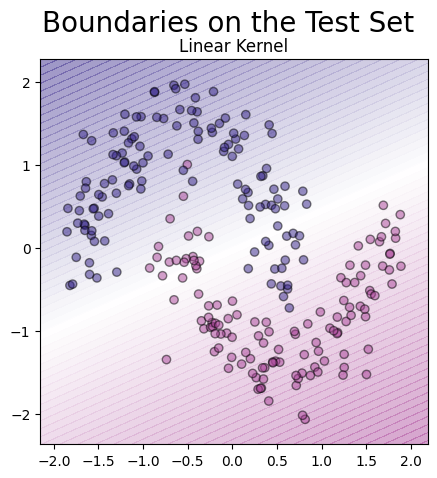

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=svc,
    X=X_test,
    grid_resolution=200,
    plot_method='contourf',
    response_method='decision_function',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Linear Kernel')
fig.suptitle('Boundaries on the Test Set', fontsize=20)
fig.show()

This doesn't fit the data correctly, we can see that the linear kernel is not designed for this dataset. In the following, we will try many different kernels:

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/3411990512.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


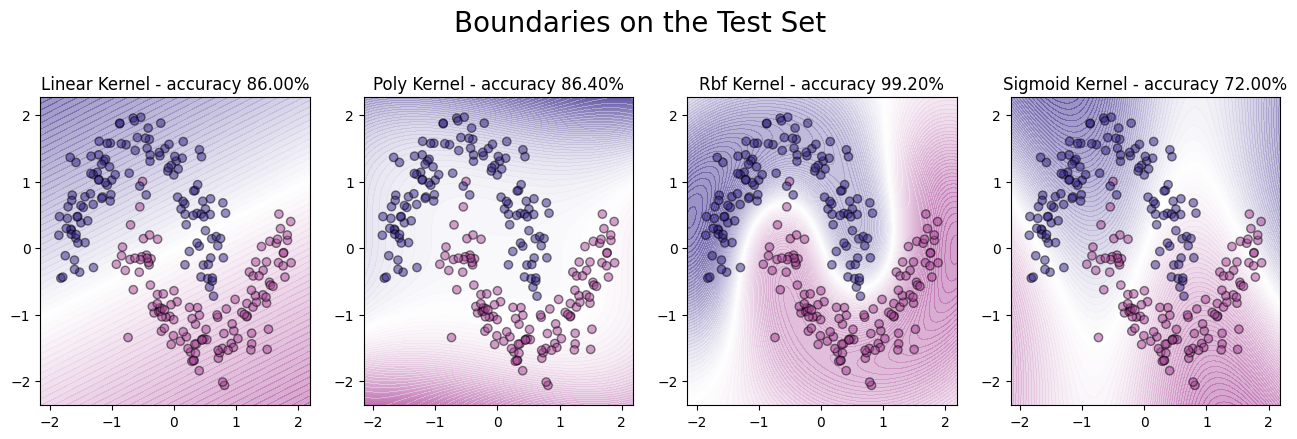

In [22]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

fig, axes = plt.subplots(1,len(kernels),figsize=(len(kernels)*4,4))

# looping over kernels
for nk, kernel in enumerate(kernels):
    ax = np.ravel(axes)[nk] # getting the current axis

    # fitting the model
    svc = SVC(kernel=kernel, random_state=random_state.next())
    svc.fit(X_train, y_train)

    # plotting the decision boundary
    dbd = DecisionBoundaryDisplay.from_estimator(
        estimator=svc,
        X=X_test,
        grid_resolution=200,
        plot_method='contourf',
        response_method='decision_function',
        ax=ax,
        cmap=binary_cmap,
        alpha=0.5,
        eps=0.3,
        levels=100,
        )
    
    # plotting the data
    ax.scatter(
        x=X_test[:,0], y=X_test[:,1], c=y_test, 
        alpha=0.5, cmap=binary_cmap, edgecolor='black'
        )

    # title
    ax.set_title(f'{kernel.title()} Kernel - '\
        f'accuracy {accuracy_score(y_test, svc.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20, y=1.1)
fig.show()

Clearly, in this example, the RBF kernel was the best!

But in which cases are the different kernels better?

In [23]:
# generating more synthetic datasets
data_dict = {
    'moons': datasets.make_moons(
        1000, noise=0.15, random_state=random_state.next()
        ),
    'circles': datasets.make_circles(
        1000, noise=0.15, factor=0.2, random_state=random_state.next()
        ),
    'blobs': datasets.make_blobs(
        1000, centers=[[1, -1], [1, 1]], cluster_std=0.3, random_state=random_state.next(),
        ),
    }

In [24]:
# kernel names
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/1929791253.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


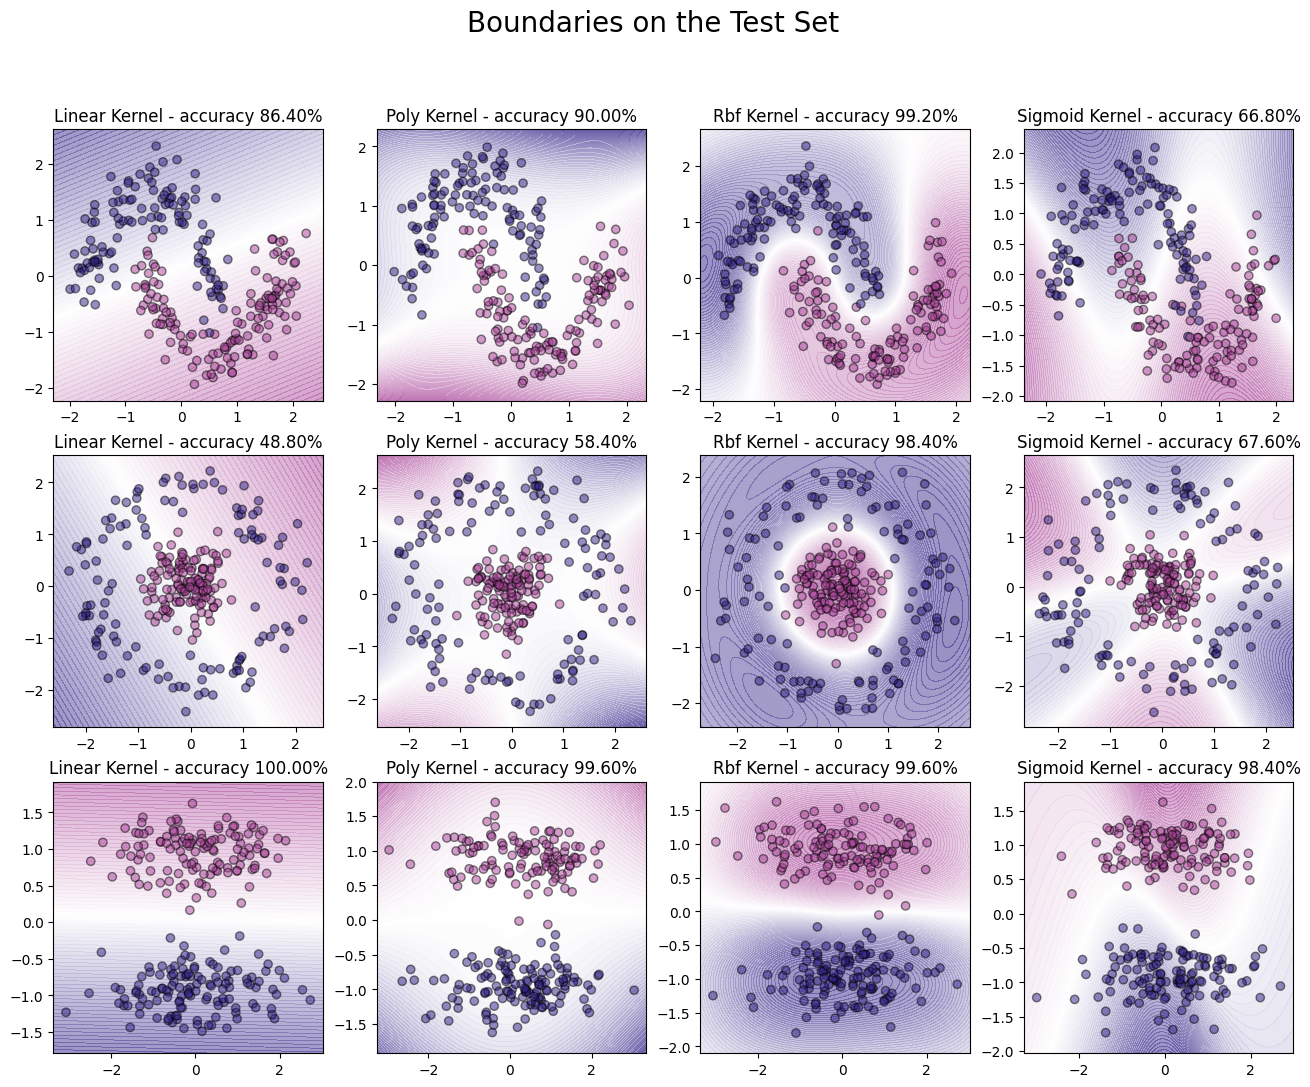

In [25]:
# plotting figure
fig, axes = plt.subplots(
    len(data_dict), len(kernels), figsize=(len(kernels)*4,len(data_dict)*4),
    )

# looping over kernels
for nd, data in enumerate(data_dict):
    for nk, kernel in enumerate(kernels):
        
        # getting the current axis
        ax = axes[nd, nk]

        # getting the data
        X, y = data_dict[data]

        # train-test splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, random_state=random_state.next()
            )

        # scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # fitting the model
        svc = SVC(kernel=kernel, random_state=random_state.next())
        svc.fit(X_train, y_train)

        # plotting the decision boundary
        dbd = DecisionBoundaryDisplay.from_estimator(
            estimator=svc,
            X=X_test,
            grid_resolution=200,
            plot_method='contourf',
            response_method='decision_function',
            ax=ax,
            cmap=binary_cmap,
            alpha=0.5,
            eps=0.3,
            levels=100,
            )
        
        # plotting the data
        ax.scatter(
            x=X_test[:,0], y=X_test[:,1], c=y_test, 
            alpha=0.5, cmap=binary_cmap, edgecolor='black'
            )

        # title
        ax.set_title(f'{kernel.title()} Kernel - '\
            f'accuracy {accuracy_score(y_test, svc.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20)
# showing plot
fig.show()

### An Example

Now that we have an understanding of how this can be used in our generated examples, let's try to use SVM to predict the classes on the breast cancer dataset that we introduced at the beginning of this notebook.

Our features are as follows:

In [26]:
bc_mean_features.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  
count     569.000000              569.000000  
mean        0.181162                0.062798  
std         0.027414                0.007060  
min         0.106000                0.049960  
25%         0.161900                0.057700  
50%         0.179200                0.061540  
75%         0.195700                0.066120  
max         0.304000                0.097440

And our targets are:

In [27]:
bc_target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [28]:
# turning data from dataframe to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We will use cross validation to understand which of the SVM models might be the best predictor of breast cancer on this dataset.

In [29]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# setting up the cross validated grid search
gscv = GridSearchCV(
    estimator=SVC(random_state=random_state.next()),                # the model
    param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},    # the parameters to change in the search
    scoring='accuracy',                                             # how to score the parameters
    refit=True,                                                     # return the best model fitted on all of the training data
    cv=5,                                                           # the number of cross-validated folds
    verbose=4,                                                      # print lots of info as the code is running
    )

In [31]:
# fitting the model on the training data, with cross validation
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....................kernel=linear;, score=0.930 total time=   0.0s
[CV 2/5] END .....................kernel=linear;, score=0.941 total time=   0.0s
[CV 3/5] END .....................kernel=linear;, score=0.882 total time=   0.0s
[CV 4/5] END .....................kernel=linear;, score=0.941 total time=   0.0s
[CV 5/5] END .....................kernel=linear;, score=0.918 total time=   0.0s
[CV 1/5] END .......................kernel=poly;, score=0.907 total time=   0.0s
[CV 2/5] END .......................kernel=poly;, score=0.918 total time=   0.0s
[CV 3/5] END .......................kernel=poly;, score=0.847 total time=   0.0s
[CV 4/5] END .......................kernel=poly;, score=0.929 total time=   0.0s
[CV 5/5] END .......................kernel=poly;, score=0.859 total time=   0.0s
[CV 1/5] END ........................kernel=rbf;, score=0.953 total time=   0.0s
[CV 2/5] END ........................kernel=rbf;,

GridSearchCV(cv=5, estimator=SVC(random_state=742779069),
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=4)

In [32]:
print('The results were:')
pd.DataFrame(gscv.cv_results_)

The results were:


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       0.001156      0.000342         0.000293        0.000061       linear   
1       0.000899      0.000033         0.000296        0.000006         poly   
2       0.001067      0.000084         0.000565        0.000065          rbf   
3       0.001066      0.000086         0.000325        0.000017      sigmoid   

                  params  split0_test_score  split1_test_score  \
0   {'kernel': 'linear'}           0.930233           0.941176   
1     {'kernel': 'poly'}           0.906977           0.917647   
2      {'kernel': 'rbf'}           0.953488           0.941176   
3  {'kernel': 'sigmoid'}           0.918605           0.952941   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.882353           0.941176           0.917647         0.922517   
1           0.847059           0.929412           0.858824         0.891984   
2           0.917647           0.964706           0.929412         0.941286   
3           0.905882           0.929412           0.917647         0.924897   

   std_test_score  rank_test_score  
0        0.021876                3  
1        0.032870                4  
2        0.016716                1  
3        0.015878                2

In [33]:
print(f"The best set of parameters was {gscv.best_params_}")

The best set of parameters was {'kernel': 'rbf'}


In [34]:
best_model = gscv.best_estimator_
best_model

SVC(random_state=742779069)

The accuracy of this model on the test data is:

In [35]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 96.50%


**CHALLENGE**: In the code cell below, train an SVC model the optimises `kernel` and `C` hyperparameters. How do different values of `C` affect the SVC decision boundary?

In [ ]:
## CODE HERE ##


## Decision Trees

The [Decision Tree Classifier](https://en.wikipedia.org/wiki/Decision_tree_learning) is a widely used machine learning algorithm that classifies data by creating a hierarchy of decision rules based on individual features. Since decision trees evaluate features independently, **scaling the data is not required**, making it a robust option for datasets with varying feature scales.

A **decision tree** works by recursively splitting the dataset into smaller, more homogeneous subsets. At each step, it evaluates the quality of potential splits using a **criterion** - a measure that guides the tree in choosing the "best" split to separate the classes effectively. 

A commonly used criterion is **[Gini Impurity](https://victorzhou.com/blog/gini-impurity/)**, which quantifies how mixed ("impure") the classes are within a subset. It measures the likelihood of misclassifying a data point if its class were assigned randomly based on the subset’s class distribution. The goal is to minimize Gini Impurity with each split, creating increasingly “pure” subsets where most data points belong to the same class. 

Another widely used criterion is **Entropy**, which is derived from information theory. Entropy measures the amount of disorder or uncertainty within a subset of data. A pure subset (all data points belonging to one class) has low entropy, while a mixed subset has higher entropy. The decision tree uses **Information Gain**, the reduction in entropy after a split, to evaluate the quality of the split. Similar to Gini Impurity, the aim is to minimize entropy and create subsets with reduced uncertainty, leading to better separation of classes.

By iteratively reducing impurity, the decision tree progressively separates classes, ultimately forming a model that classifies data points effectively.

See also: https://scikit-learn.org/stable/modules/tree.html#decision-trees

### The Basics

The decision tree classifier is easily imported from sklearn:

In [36]:
from sklearn.tree import DecisionTreeClassifier

What arguments can we supply this model and what are the defaults?

In [37]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

What each of these parameters refers to can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). We will investigate how this decision tree can be used to classify data.

Similarly to earlier, we will start by seeing how we can train, and evaluate the performance of our model, and understand the model's decision boundary.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Here are the train and test splits of a **synthetic** dataset made using [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html):

In [39]:
# make synthetic dataset
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

In [40]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/4104690370.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


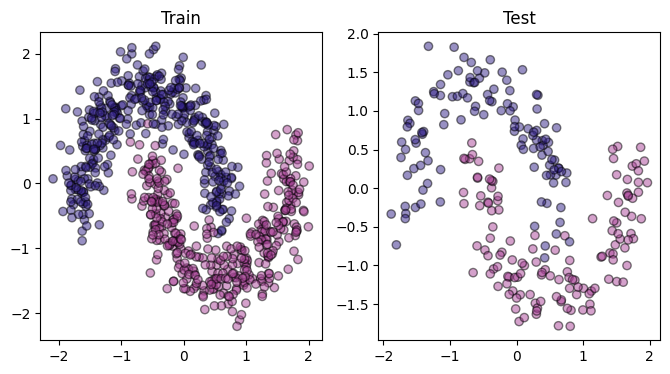

In [41]:
# plot the train and test splits for the synthetic data
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Test')

fig.show()

The model can be fit as follows:

In [42]:
# start with linear kernel
dt = DecisionTreeClassifier(random_state=random_state.next())

In [43]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=937095702)

Let's evaluate the model and see how well its decision boundary fit the data:

In [44]:
from sklearn.metrics import accuracy_score

Without any tuning, this model already performs much better than SVM. Let us try and see why.

In [45]:
print(f"The accuracy is {accuracy_score(y_test, dt.predict(X_test))*100}%")

The accuracy is 96.8%


/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/591171850.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


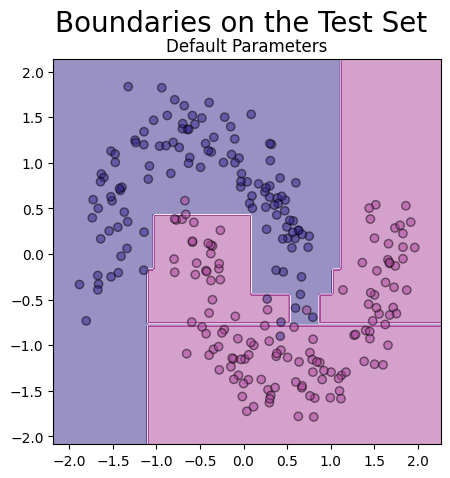

In [46]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=dt,
    X=X_test,
    grid_resolution=200,
    plot_method='contourf',
    response_method='predict_proba',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Default Parameters')
fig.suptitle('Boundaries on the Test Set', fontsize=20)
fig.show()

We can see that this mostly fits the data, but has clearly tried to over fit to the few datapoints from the pink class that fall within the purple moon.

Let's study how the max depth of the tree can effect the performance:

> **Note**: `for nmd, max_depth in enumerate(max_depths):` is used to iterate over the `max_depths` list while also keeping track of the index of each element. Here:
    >- `nmd` represents the **index** of the current element in the `max_depths` list
    >- `max_depth` represents the **value** of the current element in the `max_depths` list

> This allows you to both access each value of `max_depths` and use its corresponding index (`nmd`) within the loop, as you will see below.

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/910541339.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


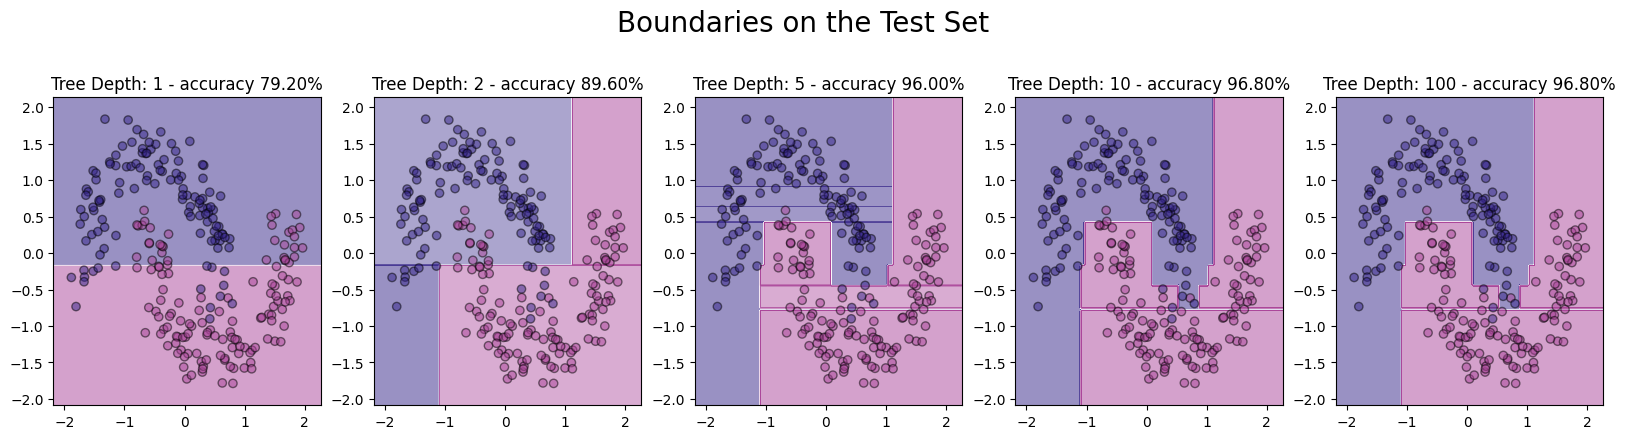

In [47]:
max_depths = [1, 2, 5, 10, 100]

fig, axes = plt.subplots(1, len(max_depths), figsize=(len(max_depths)*4,4))

# looping over max_depths
for nmd, max_depth in enumerate(max_depths):
    # getting the current axis
    ax = np.ravel(axes)[nmd]

    # fitting the model
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state.next())
    dt.fit(X_train, y_train)

    # plotting the decision boundary
    dbd = DecisionBoundaryDisplay.from_estimator(
        estimator=dt,
        X=X_test,
        grid_resolution=200,
        plot_method='contourf',
        response_method='predict_proba',
        ax=ax,
        cmap=binary_cmap,
        alpha=0.5,
        eps=0.3,
        levels=100,
        )
    
    # plotting the data
    ax.scatter(
        x=X_test[:,0], y=X_test[:,1], c=y_test, 
        alpha=0.5, cmap=binary_cmap, edgecolor='black'
        )

    # title
    ax.set_title(f'Tree Depth: {max_depth} - '\
        f'accuracy {accuracy_score(y_test, dt.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20, y=1.1)
fig.show()

Why might a tree depth of 100 and 10 produce the same results? Because any of `min_samples_split`, `min_samples_leaf`, or `min_weight_fraction_leaf` may have been met!

Let's see how this model performs over different datasets:

In [48]:
# generating more synthetic datasets
data_dict = {
    'moons': datasets.make_moons(
        1000, noise=0.15, random_state=random_state.next()
        ),
    'circles': datasets.make_circles(
        1000, noise=0.15, factor=0.2, random_state=random_state.next()
        ),
    'blobs': datasets.make_blobs(
        1000, centers=[[1, -1], [1, 1]], cluster_std=0.3, random_state=random_state.next(),
        ),
    }

In [49]:
# max depths
max_depths = [1, 2, 5, 10, 100]

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/446660014.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


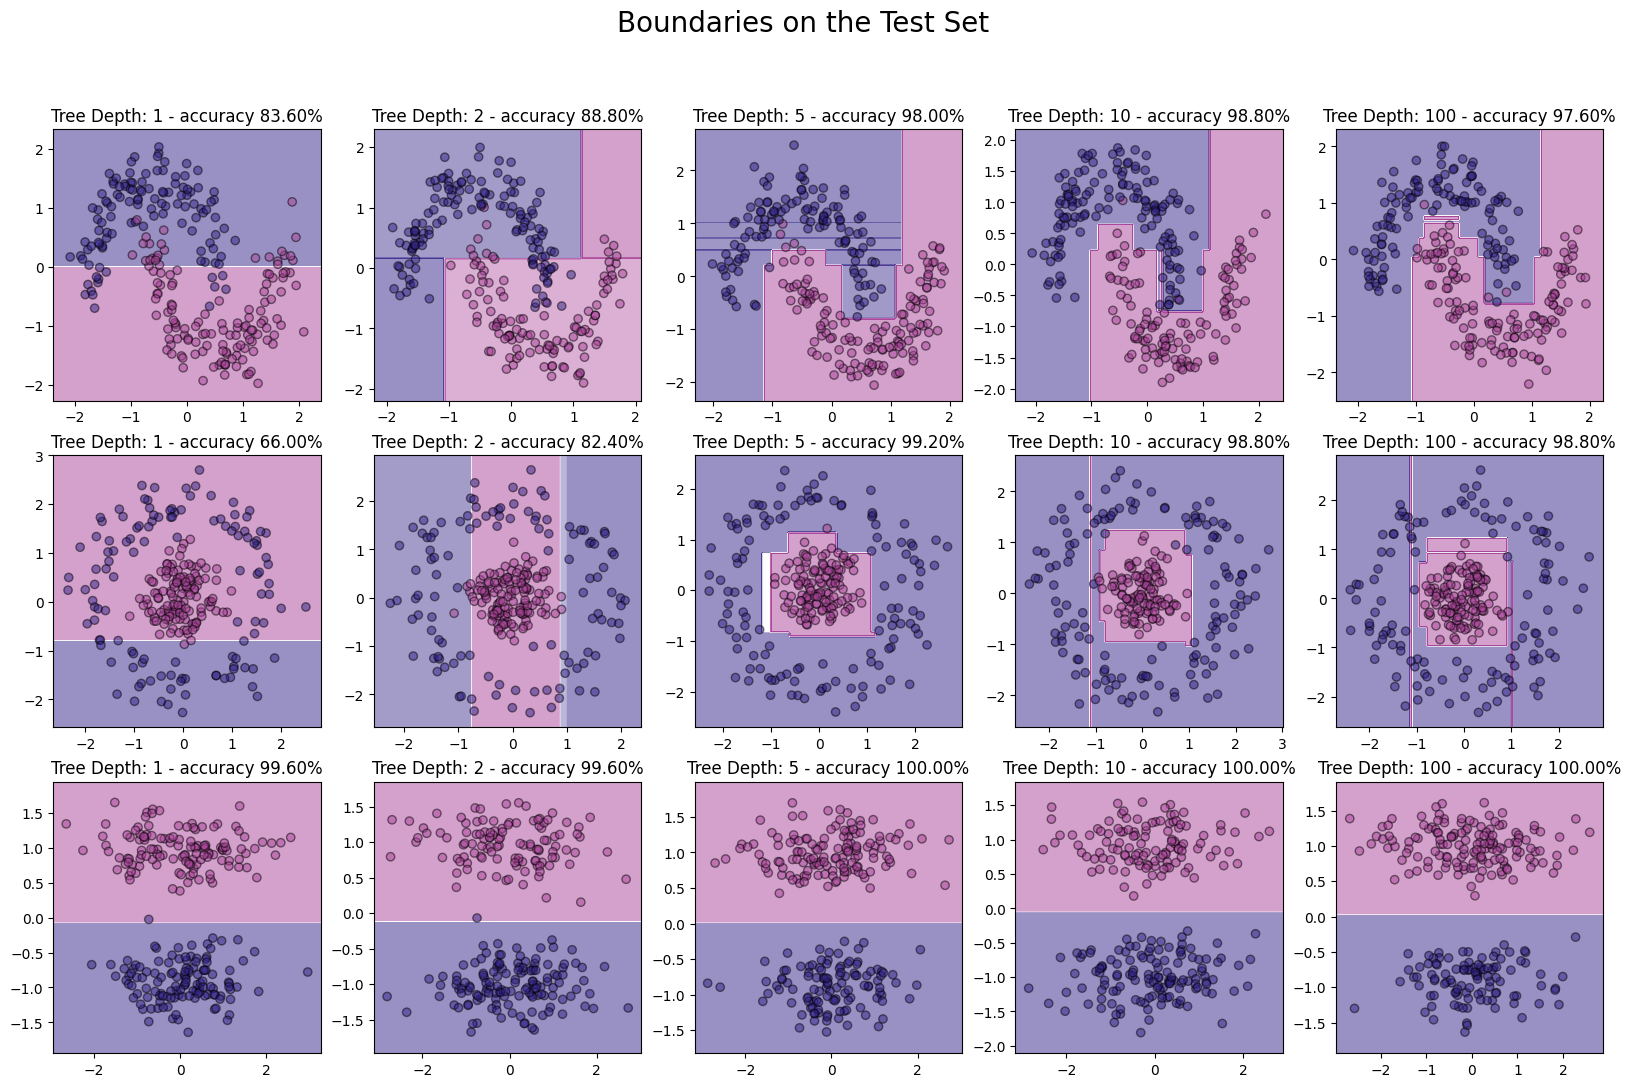

In [50]:
# plotting figure
fig, axes = plt.subplots(
    len(data_dict), len(max_depths), figsize=(len(max_depths)*4,len(data_dict)*4),
    )

# looping over max_depths
for nd, data in enumerate(data_dict):
    for nmd, max_depth in enumerate(max_depths):
        
        # getting the current axis
        ax = axes[nd, nmd]

        # getting the data
        X, y = data_dict[data]

        # train-test splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, random_state=random_state.next()
            )

        # scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # fitting the model
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state.next())
        dt.fit(X_train, y_train)

        # plotting the decision boundary
        dbd = DecisionBoundaryDisplay.from_estimator(
            estimator=dt,
            X=X_test,
            grid_resolution=200,
            plot_method='contourf',
            response_method='predict_proba',
            ax=ax,
            cmap=binary_cmap,
            alpha=0.5,
            eps=0.3,
            levels=100,
            )
        
        # plotting the data
        ax.scatter(
            x=X_test[:,0], y=X_test[:,1], c=y_test, 
            alpha=0.5, cmap=binary_cmap, edgecolor='black'
            )

        # title
        ax.set_title(f'Tree Depth: {max_depth} - '\
            f'accuracy {accuracy_score(y_test, dt.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20)
# showing plot
fig.show()

### An Example

Now that we have an understanding of how this can be used in our generated examples, let's try to use a Decision Tree to predict the classes on the breast cancer dataset that we introduced at the beginning of this notebook.

Our features are as follows:

In [51]:
bc_mean_features.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  
count     569.000000              569.000000  
mean        0.181162                0.062798  
std         0.027414                0.007060  
min         0.106000                0.049960  
25%         0.161900                0.057700  
50%         0.179200                0.061540  
75%         0.195700                0.066120  
max         0.304000                0.097440

And our targets are:

In [52]:
bc_target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [53]:
# turning data from table to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We will use cross validation to understand which parameters in the DT models might be the best predictor of breast cancer on this dataset. We will test different max depths and criterions.

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
# setting up the cross validated grid search
gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_state.next()), # the model
    param_grid={ # the parameters to change in the search
        'max_depth': [1, 2, 5, 10, 20, 50, 100,], # max depth
        'criterion': ['gini', 'entropy', 'log_loss'], # criterion
        }, 
    scoring='accuracy', # how to score the parameters
    refit=True,         # return the best model fitted on all of the training data
    cv=5,               # the number of cross-validated folds
    verbose=1,          # print lots of info as the code is running
    )

In [56]:
# fitting the model on the training data, with cross validation
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=61397107),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [57]:
print('The results were:')
pd.DataFrame(gscv.cv_results_).head()

The results were:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.000562      0.000063         0.000197        0.000018   
1       0.000703      0.000006         0.000175        0.000001   
2       0.001097      0.000086         0.000175        0.000005   
3       0.001223      0.000090         0.000252        0.000035   
4       0.001148      0.000087         0.000187        0.000006   

  param_criterion param_max_depth                                  params  \
0            gini               1   {'criterion': 'gini', 'max_depth': 1}   
1            gini               2   {'criterion': 'gini', 'max_depth': 2}   
2            gini               5   {'criterion': 'gini', 'max_depth': 5}   
3            gini              10  {'criterion': 'gini', 'max_depth': 10}   
4            gini              20  {'criterion': 'gini', 'max_depth': 20}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.941860           0.870588           0.870588           0.870588   
1           0.930233           0.894118           0.894118           0.905882   
2           0.953488           0.870588           0.941176           0.917647   
3           0.918605           0.858824           0.941176           0.905882   
4           0.918605           0.858824           0.941176           0.905882   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.882353         0.887196        0.027710               19  
1           0.882353         0.901341        0.016250               16  
2           0.882353         0.913051        0.032227                3  
3           0.882353         0.901368        0.028544               12  
4           0.882353         0.901368        0.028544               12

In [58]:
print(f"The best set of parameters was {gscv.best_params_}")

The best set of parameters was {'criterion': 'entropy', 'max_depth': 5}


In [59]:
best_model = gscv.best_estimator_
best_model

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=61397107)

The accuracy of this model on the test data is:

In [60]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 93.01%


## Random Forest

[Random Forest](https://en.wikipedia.org/wiki/Random_forest) is a classifier that is built on top of the work done by Decision Trees and is a type of ensemble learning model. This is because it uses a "forest" of decision trees when classifying data. 

During training, many decision trees are built based on different random splits of the features and data (depending on the parameters), and during testing, the predictions of these trees are combined to get a single prediction.

See also https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

### The Basics

The decision tree classifier is easily imported from sklearn:

In [61]:
from sklearn.ensemble import RandomForestClassifier

What arguments can we supply this model and what are the defaults?

In [62]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

What each of these parameters refers to can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We will investigate how this random forest can be used to classify data:

Similarly to earlier, we will start by seeing how we can train, and evaluate the performance of our model, and understand the model's decision boundary.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Here are the train and test splits of a **synthetic** dataset made using [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html):

In [64]:
# make synthetic dataset
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

In [65]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/4104690370.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


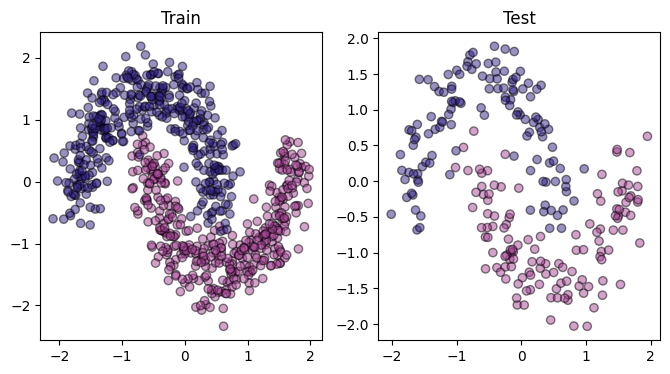

In [66]:
# plot the train and test splits for the synthetic data
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Test')

fig.show()

The model can be fit as follows:

In [67]:
# start with linear kernel
rf = RandomForestClassifier(random_state=random_state.next())

In [68]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=139386294)

Let's evaluate the model and see how well its decision boundary fit the data:

In [69]:
from sklearn.metrics import accuracy_score

In [70]:
print(f"The accuracy is {accuracy_score(y_test, rf.predict(X_test))*100}%")

The accuracy is 97.6%


Without any tuning, this model already performs much better than SVM. Let us try and see why.

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/1647388345.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


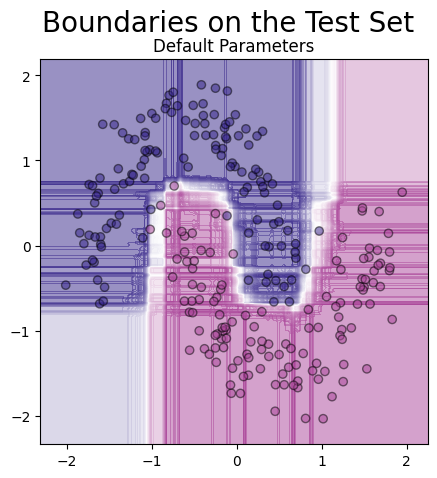

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=rf,
    X=X_test,
    grid_resolution=200,
    plot_method='contourf',
    response_method='predict_proba',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Default Parameters')
fig.suptitle('Boundaries on the Test Set', fontsize=20)
plt.show()

We can see that this fits the data much better than Decision Trees!

Let's study how the number of trees in the forest can effect the performance:

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/3479196455.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


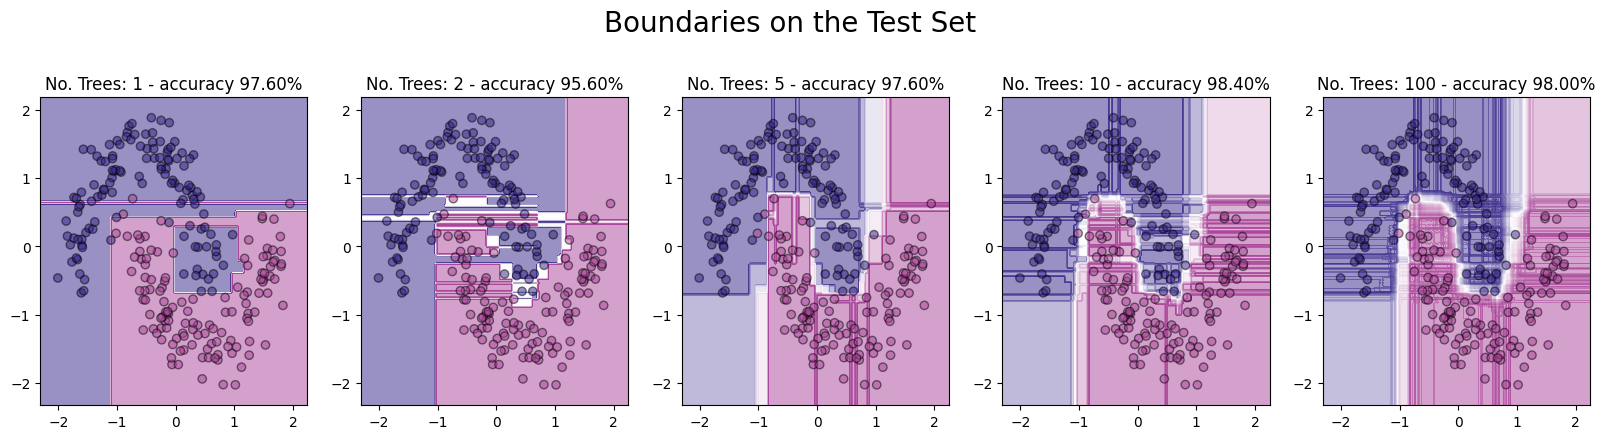

In [72]:
n_trees = [1, 2, 5, 10, 100,]

fig, axes = plt.subplots(1, len(n_trees), figsize=(len(n_trees)*4,4))

# looping over n_trees
for nmd, n_estimators in enumerate(n_trees):
    # getting the current axis
    ax = np.ravel(axes)[nmd]

    # fitting the model
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state.next())
    rf.fit(X_train, y_train)

    # plotting the decision boundary
    dbd = DecisionBoundaryDisplay.from_estimator(
        estimator=rf,
        X=X_test,
        grid_resolution=200,
        plot_method='contourf',
        response_method='predict_proba',
        ax=ax,
        cmap=binary_cmap,
        alpha=0.5,
        eps=0.3,
        levels=100,
        )
    
    # plotting the data
    ax.scatter(
        x=X_test[:,0], y=X_test[:,1], c=y_test, 
        alpha=0.5, cmap=binary_cmap, edgecolor='black'
        )

    # title
    ax.set_title(f'No. Trees: {n_estimators} - '\
        f'accuracy {accuracy_score(y_test, rf.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20, y=1.1)
fig.show()

Here, because multiple trees are used, and each of them is acting over a subset of the data, Random Forest is less likely to over-fit to the data compared to a single decision tree acting over all of the training data.

We see that even with a small number of trees, the performance is good!

Let's see how this model performs over different datasets:

In [73]:
# generating more synthetic datasets
data_dict = {
    'moons': datasets.make_moons(
        1000, noise=0.15, random_state=random_state.next()
        ),
    'circles': datasets.make_circles(
        1000, noise=0.15, factor=0.2, random_state=random_state.next()
        ),
    'blobs': datasets.make_blobs(
        1000, centers=[[1, -1], [1, 1]], cluster_std=0.3, random_state=random_state.next(),
        ),
    }

In [74]:
# number of trees
n_trees = [1, 2, 5, 10, 100,]

/var/folders/dn/w2011ntd5gxf26dgf_38535m0000gp/T/ipykernel_10860/1986406632.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


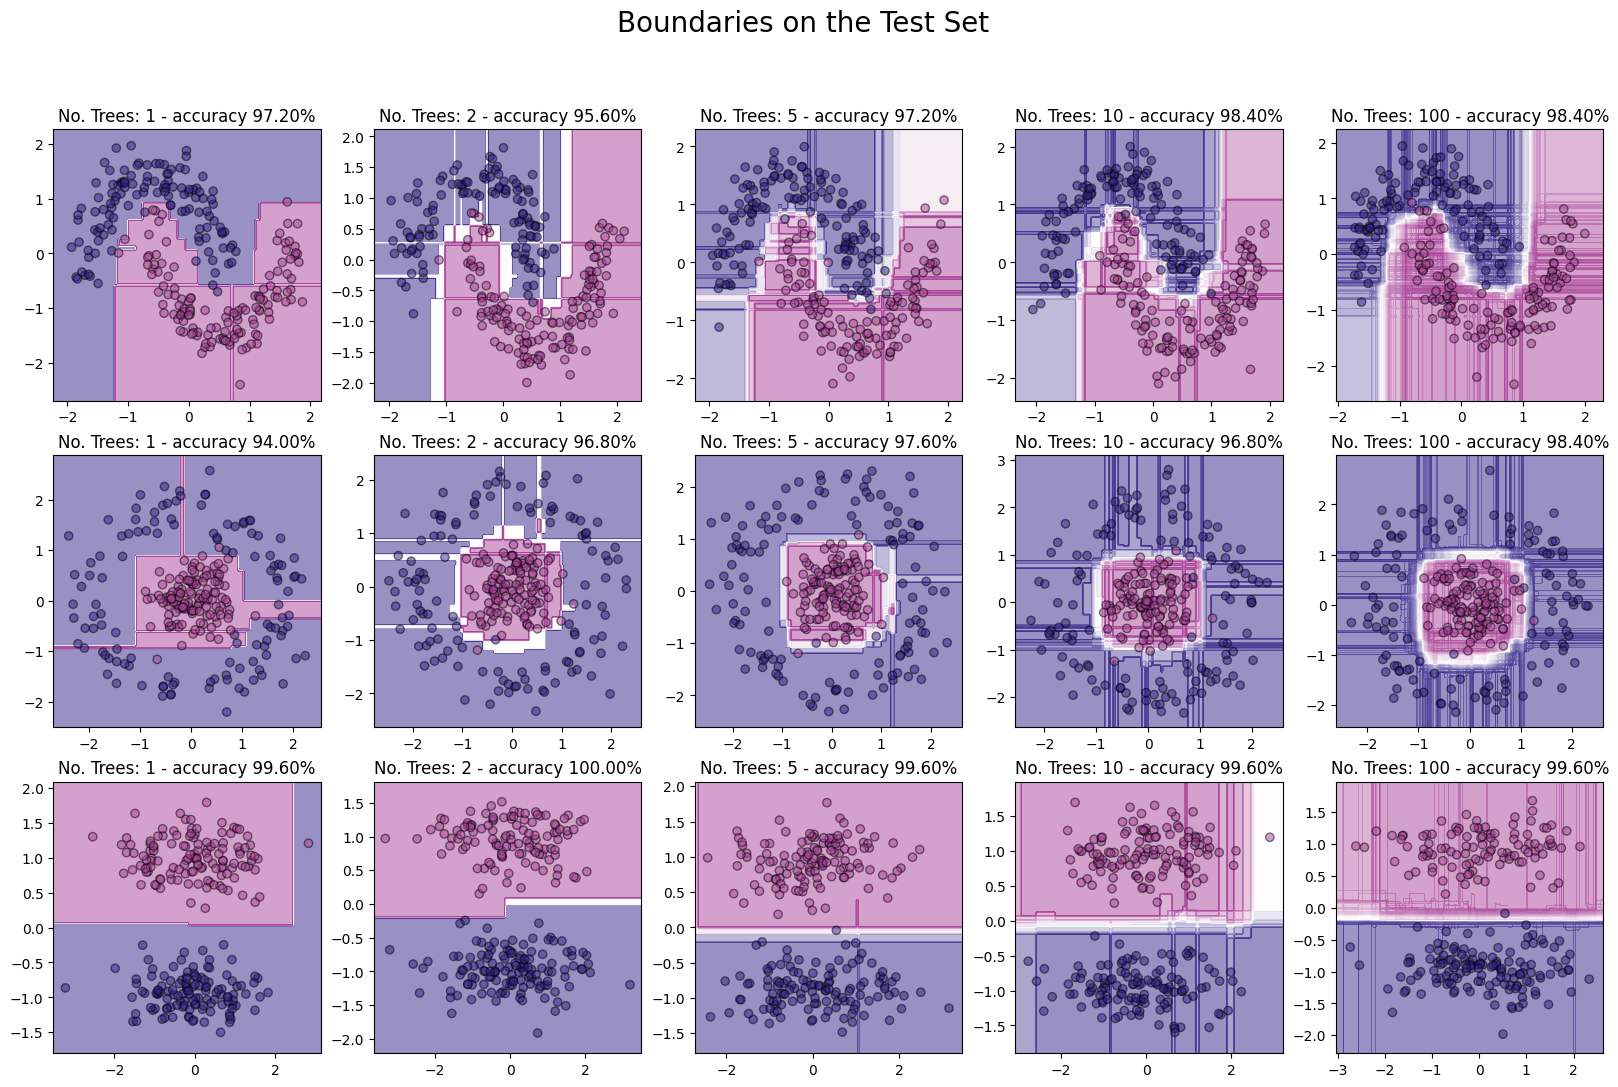

In [75]:
# plotting figure
fig, axes = plt.subplots(
    len(data_dict), len(n_trees), figsize=(len(n_trees)*4,len(data_dict)*4),
    )

# looping over n_trees
for nd, data in enumerate(data_dict):
    for nmd, n_estimators in enumerate(n_trees):
        
        # getting the current axis
        ax = axes[nd, nmd]

        # getting the data
        X, y = data_dict[data]

        # train-test splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, random_state=random_state.next()
            )

        # scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # fitting the model
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state.next())
        rf.fit(X_train, y_train)

        # plotting the decision boundary
        dbd = DecisionBoundaryDisplay.from_estimator(
            estimator=rf,
            X=X_test,
            grid_resolution=200,
            plot_method='contourf',
            response_method='predict_proba',
            ax=ax,
            cmap=binary_cmap,
            alpha=0.5,
            eps=0.3,
            levels=100,
            )
        
        # plotting the data
        ax.scatter(
            x=X_test[:,0], y=X_test[:,1], c=y_test, 
            alpha=0.5, cmap=binary_cmap, edgecolor='black'
            )

        # title
        ax.set_title(f'No. Trees: {n_estimators} - '\
            f'accuracy {accuracy_score(y_test, rf.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20)
# showing plot
fig.show()

### An Example

Now that we have an understanding of how this can be used in our generated examples, let's try to use a Random Forest to predict the classes on the breast cancer dataset that we introduced at the beginning of this notebook.

Our features are as follows:

In [76]:
bc_mean_features.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  
count     569.000000              569.000000  
mean        0.181162                0.062798  
std         0.027414                0.007060  
min         0.106000                0.049960  
25%         0.161900                0.057700  
50%         0.179200                0.061540  
75%         0.195700                0.066120  
max         0.304000                0.097440

And our targets are:

In [77]:
bc_target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [78]:
# turning data from table to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We will use cross validation to understand which parameters in the RandomForest models might be the best predictors of breast cancer on this dataset. We will test different max depths, criterions, and number of trees.

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
# setting up the cross validated grid search
gscv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=random_state.next()), # the model
    param_grid={ # the parameters to change in the search
        'max_depth': [1, 2, 5, 10, 20, 50, 100,],       # max depth
        'criterion': ['gini', 'entropy', 'log_loss'],   # criterion
        'n_estimators': [1, 2, 5, 10, 100, 200],        # number of trees in your random forest
        }, 
    scoring='accuracy', # how to score the parameters
    refit=True,         # return the best model fitted on all of the training data
    cv=5,               # the number of cross-validated folds
    verbose=1,          # print lots of info as the code is running
    )

In [81]:
# fitting the model on the training data, with cross validation
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=751914956),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 5, 10, 20, 50, 100],
                         'n_estimators': [1, 2, 5, 10, 100, 200]},
             scoring='accuracy', verbose=1)

In [82]:
print('The results were:')
pd.DataFrame(gscv.cv_results_).head()

The results were:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001034      0.000353         0.000332        0.000127   
1       0.001675      0.000573         0.000521        0.000247   
2       0.003179      0.000909         0.000449        0.000025   
3       0.005633      0.001111         0.000557        0.000030   
4       0.046229      0.000701         0.002147        0.000195   

  param_criterion param_max_depth param_n_estimators  \
0            gini               1                  1   
1            gini               1                  2   
2            gini               1                  5   
3            gini               1                 10   
4            gini               1                100   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 1, 'n_estim...           0.930233   
1  {'criterion': 'gini', 'max_depth': 1, 'n_estim...           0.930233   
2  {'criterion': 'gini', 'max_depth': 1, 'n_estim...           0.953488   
3  {'criterion': 'gini', 'max_depth': 1, 'n_estim...           0.953488   
4  {'criterion': 'gini', 'max_depth': 1, 'n_estim...           0.941860   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.882353           0.905882           0.941176           0.929412   
1           0.882353           0.905882           0.941176           0.929412   
2           0.917647           0.917647           0.917647           0.905882   
3           0.882353           0.917647           0.870588           0.905882   
4           0.870588           0.941176           0.929412           0.941176   

   mean_test_score  std_test_score  rank_test_score  
0         0.917811        0.021139               75  
1         0.917811        0.021139               75  
2         0.922462        0.016168               71  
3         0.905992        0.028997              116  
4         0.924843        0.027523               64

In [83]:
print(f"The best set of parameters was {gscv.best_params_}")

The best set of parameters was {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}


In [84]:
best_model = gscv.best_estimator_
best_model

RandomForestClassifier(criterion='entropy', max_depth=10,
                       random_state=751914956)

The accuracy of this model on the test data is:

In [85]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 95.80%


## Can we Ensemble Anything?

YES! Depending on how much effort you want to put in... There are lots of different ensemble options that you might have fun trying out. https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

Also for this example, we will introduce `Pipeline`, which is a way of chaining together different models in sklearn.

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import sklearn.ensemble as skensemble

In [87]:
# turning data from table to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

Because we used `Pipeline`, there is no need to scale the data first, since our scaler is part of the pipeline.

The `AdaboostClassifier` is an ensemble method that combines multiple weak learners to create a stronger overall model. It adapts by adjusting the weights of the misclassified samples and focuses more on difficult cases. 

Below is an example of Adaboost with `LogisticRegression`:

In [88]:
clf = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        (
            'classifier', 
            skensemble.AdaBoostClassifier(
                estimator=LogisticRegression(random_state=random_state.next()),
                random_state=random_state.next(),
                n_estimators=1000, # the maximum number of estimators
            )
        ),
    ]
)

clf.fit(X_train, y_train)

print(f"The test accuracy is {accuracy_score(y_test, clf.predict(X_test))*100:.2f}%")

The test accuracy is 93.01%


Adaboost with `GaussianNB`:

In [89]:
clf = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        (
            'classifier', 
            skensemble.AdaBoostClassifier(
                estimator=GaussianNB(),
                random_state=random_state.next(),
                n_estimators=1000, # the maximum number of estimators
            )
        ),
    ]
)

clf.fit(X_train, y_train)

print(f"The test accuracy is {accuracy_score(y_test, clf.predict(X_test))*100:.2f}%")

The test accuracy is 92.31%


### And some weird things...

Example 1:

In [90]:
clf = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        (
            'classifier', 
            skensemble.StackingClassifier(
                estimators=[
                    ('lr', LogisticRegression(random_state=random_state.next())),
                    ('rf', RandomForestClassifier(random_state=random_state.next())),
                    ('svc', SVC(random_state=random_state.next())),
                ],
                final_estimator=LogisticRegression(random_state=random_state.next()),
            ),
        )
    ]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('lr',
                                                 LogisticRegression(random_state=754367260)),
                                                ('rf',
                                                 RandomForestClassifier(random_state=214823001)),
                                                ('svc',
                                                 SVC(random_state=498986079))],
                                    final_estimator=LogisticRegression(random_state=136530674)))])

In [91]:
print(f"The test accuracy is {accuracy_score(y_test, clf.predict(X_test))*100:.2f}%")

The test accuracy is 96.50%


Example 2:

In [92]:
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            skensemble.StackingClassifier(
                estimators=[
                    (
                        "hgbt",
                        skensemble.HistGradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                    (
                        "gbt",
                        skensemble.GradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                    (
                        "rf",
                        skensemble.RandomForestClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                ],
                final_estimator=LogisticRegression(random_state=random_state.next()),
            ),
        ),
    ]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('hgbt',
                                                 HistGradientBoostingClassifier(random_state=710432402)),
                                                ('gbt',
                                                 GradientBoostingClassifier(random_state=560674123)),
                                                ('rf',
                                                 RandomForestClassifier(random_state=85695007))],
                                    final_estimator=LogisticRegression(random_state=53642287)))])

In [93]:
print(f"The test accuracy is {accuracy_score(y_test, clf.predict(X_test))*100:.2f}%")

The test accuracy is 95.80%


Example 3:

In [94]:
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            skensemble.StackingClassifier(
                estimators=[
                    (
                        "stack1",
                        skensemble.StackingClassifier(
                            estimators=[
                                (
                                    "hgbt",
                                    skensemble.HistGradientBoostingClassifier(
                                        random_state=random_state.next()
                                    ),
                                ),
                                (
                                    "gbt",
                                    skensemble.GradientBoostingClassifier(
                                        random_state=random_state.next()
                                    ),
                                ),
                                (
                                    "rf",
                                    skensemble.RandomForestClassifier(
                                        random_state=random_state.next()
                                    ),
                                ),
                            ],
                            final_estimator=LogisticRegression(
                                random_state=random_state.next()
                            ),
                        ),
                    ),
                    (
                        "stack2",
                        skensemble.StackingClassifier(
                            estimators=[
                                (
                                    "hgbt",
                                    skensemble.HistGradientBoostingClassifier(
                                        random_state=random_state.next()
                                    ),
                                ),
                                (
                                    "gbt",
                                    skensemble.GradientBoostingClassifier(
                                        random_state=random_state.next()
                                    ),
                                ),
                                (
                                    "rf",
                                    skensemble.RandomForestClassifier(
                                        random_state=random_state.next()
                                    ),
                                ),
                            ],
                            final_estimator=LogisticRegression(
                                random_state=random_state.next()
                            ),
                        ),
                    ),
                ],
                final_estimator=skensemble.HistGradientBoostingClassifier(
                    random_state=random_state.next()
                ),
            ),
        ),
    ]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('stack1',
                                                 StackingClassifier(estimators=[('hgbt',
                                                                                 HistGradientBoostingClassifier(random_state=934737323)),
                                                                                ('gbt',
                                                                                 GradientBoostingClassifier(random_state=784756515)),
                                                                                ('rf',
                                                                                 RandomForestClassifier(random_state=816788563))],
                                                                    final_estimator=LogisticRegression(random_...
                                                ('stack2',
                                                 StackingClassifier(estimators=[('hgbt',
                                                                                 HistGradientBoostingClassifier(random_state=974616216)),
                                                                                ('gbt',
                                                                                 GradientBoostingClassifier(random_state=466172020)),
                                                                                ('rf',
                                                                                 RandomForestClassifier(random_state=339248706))],
                                                                    final_estimator=LogisticRegression(random_state=450540937)))],
                                    final_estimator=HistGradientBoostingClassifier(random_state=636977740)))])

In [95]:
print(f"The test accuracy is {accuracy_score(y_test, clf.predict(X_test))*100:.2f}%")

The test accuracy is 93.71%


Example 4: with a voting classifier:

In [96]:
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            skensemble.VotingClassifier(
                estimators=[
                    (
                        "hgbt",
                        skensemble.HistGradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                    (
                        "gbt",
                        skensemble.GradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                    (
                        "rf",
                        skensemble.RandomForestClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                ]
            ),
        ),
    ]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('hgbt',
                                               HistGradientBoostingClassifier(random_state=445535299)),
                                              ('gbt',
                                               GradientBoostingClassifier(random_state=303021925)),
                                              ('rf',
                                               RandomForestClassifier(random_state=946349841))]))])

In [97]:
print(f"The test accuracy is {accuracy_score(y_test, clf.predict(X_test))*100:.2f}%")

The test accuracy is 94.41%


Finally, we can even do grid searches over these models to find the best parameters:

In [98]:
from sklearn.model_selection import RandomizedSearchCV

In [99]:
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            skensemble.StackingClassifier(
                estimators=[
                    (
                        "hgbt1",
                        skensemble.HistGradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                    (
                        "hgbt2",
                        skensemble.HistGradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                    (
                        "hgbt3",
                        skensemble.HistGradientBoostingClassifier(
                            random_state=random_state.next()
                        ),
                    ),
                ],
                final_estimator=LogisticRegression(random_state=random_state.next()),
            ),
        ),
    ]
)

In [100]:
# setting up the cross validated grid search
rscv = RandomizedSearchCV(
    estimator=clf,  # the model
    param_distributions={  # the parameters to change in the search
        "classifier__hgbt1__learning_rate": [0.1, 0.5, 1.0],
        "classifier__hgbt1__max_depth": [1, 100, 500, None],
        "classifier__hgbt1__l2_regularization": [0, 1e-3, 1e-1, 1e1, 1e3],
        "classifier__hgbt2__learning_rate": [0.1, 0.5, 1.0],
        "classifier__hgbt2__max_depth": [1, 100, 500, None],
        "classifier__hgbt2__l2_regularization": [0, 1e-3, 1e-1, 1e1, 1e3],
        "classifier__hgbt3__learning_rate": [0.1, 0.5, 1.0],
        "classifier__hgbt3__max_depth": [1, 100, 500, None],
        "classifier__hgbt3__l2_regularization": [0, 1e-3, 1e-1, 1e1, 1e3],
    },
    scoring="accuracy",  # how to score the parameters
    refit=True,  # return the best model fitted on all of the training data
    cv=5,  # the number of cross-validated folds
    verbose=1,  # print lots of info as the code is running
    n_iter=10,
    random_state=random_state.next(),
)

In [101]:
# fitting the model on the training data, with cross validation
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              StackingClassifier(estimators=[('hgbt1',
                                                                              HistGradientBoostingClassifier(random_state=810936851)),
                                                                             ('hgbt2',
                                                                              HistGradientBoostingClassifier(random_state=376923029)),
                                                                             ('hgbt3',
                                                                              HistGradientBoostingClassifier(random_state=342617634))],
                                                                 final_estimator=LogisticRegress...
                                        'classifier__hgbt2__l2_regularization': [0,
                                                                                 0.001,
                                                                                 0.1,
                                                                                 10.0,
                                                                                 1000.0],
                                        'classifier__hgbt2__learning_rate': [0.1,
                                                                             0.5,
                                                                             1.0],
                                        'classifier__hgbt2__max_depth': [1, 100,
                                                                         500,
                                                                         None],
                                        'classifier__hgbt3__l2_regularization': [0,
                                                                                 0.001,
                                                                                 0.1,
                                                                                 10.0,
                                                                                 1000.0],
                                        'classifier__hgbt3__learning_rate': [0.1,
                                                                             0.5,
                                                                             1.0],
                                        'classifier__hgbt3__max_depth': [1, 100,
                                                                         500,
                                                                         None]},
                   random_state=13725334, scoring='accuracy', verbose=1)

In [102]:
print(f"The best set of parameters was {rscv.best_params_}")

The best set of parameters was {'classifier__hgbt3__max_depth': 100, 'classifier__hgbt3__learning_rate': 0.5, 'classifier__hgbt3__l2_regularization': 0.1, 'classifier__hgbt2__max_depth': 100, 'classifier__hgbt2__learning_rate': 0.1, 'classifier__hgbt2__l2_regularization': 0.001, 'classifier__hgbt1__max_depth': 500, 'classifier__hgbt1__learning_rate': 1.0, 'classifier__hgbt1__l2_regularization': 1000.0}


In [103]:
best_model = rscv.best_estimator_
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('hgbt1',
                                                 HistGradientBoostingClassifier(l2_regularization=1000.0,
                                                                                learning_rate=1.0,
                                                                                max_depth=500,
                                                                                random_state=810936851)),
                                                ('hgbt2',
                                                 HistGradientBoostingClassifier(l2_regularization=0.001,
                                                                                max_depth=100,
                                                                                random_state=376923029)),
                                                ('hgbt3',
                                                 HistGradientBoostingClassifier(l2_regularization=0.1,
                                                                                learning_rate=0.5,
                                                                                max_depth=100,
                                                                                random_state=342617634))],
                                    final_estimator=LogisticRegression(random_state=309875385)))])

The accuracy of this model on the test data is:

In [104]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 95.80%
